## Peter Chika Ozo-ogueji(AU ID: 5263783)
## FIN-666 Homework-6
### Part-11

## Dow Jones Industrial Average (DJIA) index, at daily frequency, for the past five years.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from scipy.stats.distributions import chi2

from statsmodels.tsa.arima.model import ARIMA

In [4]:
djia = pd.read_csv('DJIA.csv', header=0, index_col=0, na_values=".")
djia.index = pd.to_datetime(djia.index)
djia = djia.ffill()
djia = djia['2020':'2025']
djia.columns = ['DJIA']
djia.head(3)

,DJIA
observation_date,
2020-03-09,23851.02
2020-03-10,25018.16
2020-03-11,23553.22


## Calculate daily returns in percentage points

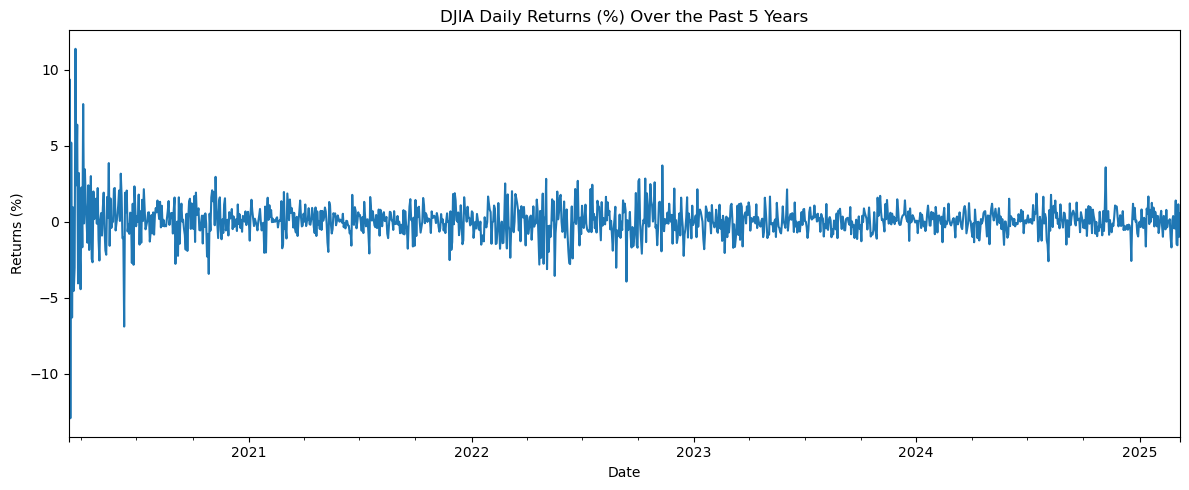

In [18]:
# Calculate daily returns in percentage points
djia['ret'] = djia.DJIA.pct_change() * 100
djia = djia.dropna()  # Remove the first row with NaN return

# Plot the daily returns
plt.figure(figsize=(12, 5))
djia.ret.plot(figsize=(12, 5))
plt.title("DJIA Daily Returns (%) Over the Past 5 Years")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.tight_layout()
plt.show()

## Calculate squared returns (volatility)

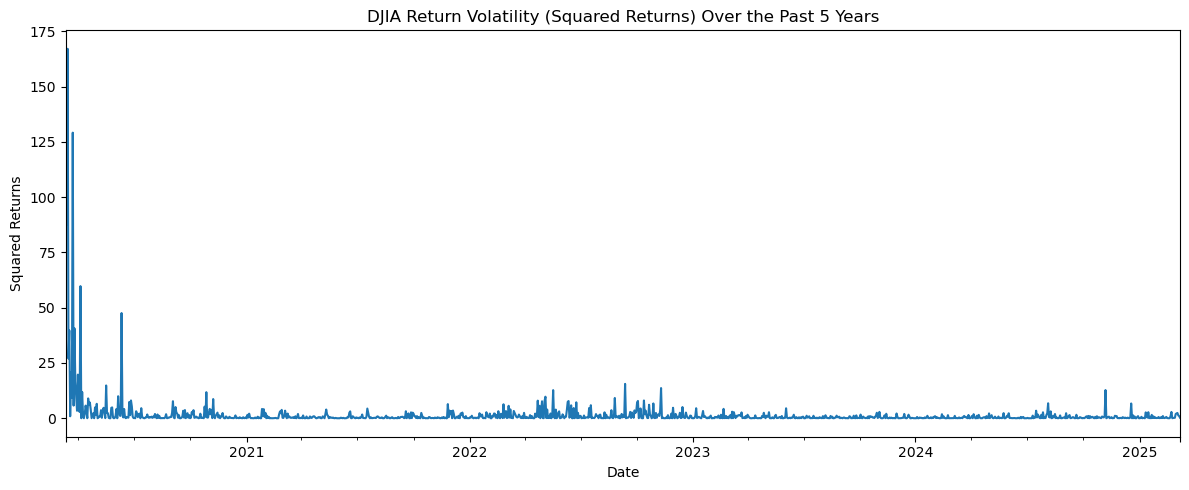

In [23]:
# Calculate squared returns (volatility)
djia['sqret'] = djia.ret.mul(djia.ret)

# Plot the volatility (squared returns)
plt.figure(figsize=(12, 5))
djia.sqret.plot(figsize=(12, 5))
plt.title("DJIA Return Volatility (Squared Returns) Over the Past 5 Years")
plt.xlabel("Date")
plt.ylabel("Squared Returns")
plt.tight_layout()
plt.show()

## Check for autocorrelation in returns

<Figure size 1000x600 with 0 Axes>

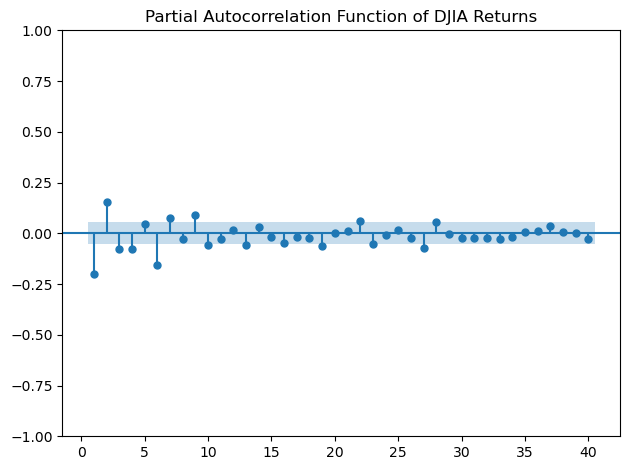

In [26]:
plt.figure(figsize=(10, 6))
sgt.plot_pacf(djia.ret, lags=40, zero=False, alpha=0.05)
plt.title("Partial Autocorrelation Function of DJIA Returns")
plt.tight_layout()
plt.show()

## Check for autocorrelation in squared returns (volatility)

<Figure size 1000x600 with 0 Axes>

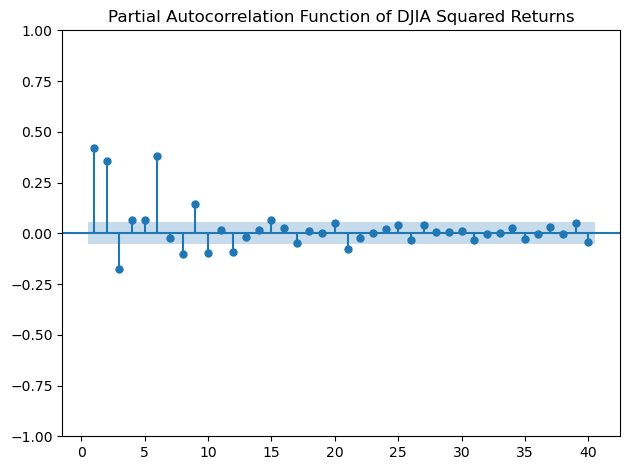

In [29]:
# Check for autocorrelation in squared returns (volatility)
plt.figure(figsize=(10, 6))
sgt.plot_pacf(djia.sqret, lags=40, zero=False, alpha=0.05)
plt.title("Partial Autocorrelation Function of DJIA Squared Returns")
plt.tight_layout()
plt.show()

## Display descriptive statistics for returns

In [32]:
# Display descriptive statistics for returns
print("Descriptive Statistics for DJIA Returns:")
print(djia.ret.describe())

Descriptive Statistics for DJIA Returns:
count    1302.000000
mean        0.053326
std         1.217156
min       -12.926547
25%        -0.440927
50%         0.039274
75%         0.589380
max        11.365038
Name: ret, dtype: float64


## Check for ARCH effects using Ljung-Box test on squared returns

In [35]:
# Check for ARCH effects using Ljung-Box test on squared returns
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(djia.sqret, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box Test for ARCH Effects (on squared returns):")
print(lb_test)


Ljung-Box Test for ARCH Effects (on squared returns):
        lb_stat      lb_pvalue
10  1098.456424  1.135500e-229
20  1197.124378  3.079875e-241
30  1207.940022  5.048146e-235


In [37]:
# Alternatively, import the arch package and fit a basic ARCH model
from arch import arch_model

## Fit an ARCH(1) model

In [40]:
# Fit an ARCH(1) model
model_arch1 = arch_model(djia.ret, mean='Constant', vol='ARCH', p=1)
res_arch1 = model_arch1.fit(disp='off')
print("\nARCH(1) Model Results:")
print(res_arch1.summary().tables[1])


ARCH(1) Model Results:
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0809  2.839e-02      2.851  4.360e-03 [2.530e-02,  0.137]


## Fit a GARCH(1,1) model

In [43]:
# Fit a GARCH(1,1) model
model_garch = arch_model(djia.ret, mean='Constant', vol='GARCH', p=1, q=1)
res_garch = model_garch.fit(disp='off')
print("\nGARCH(1,1) Model Results:")
print(res_garch.summary().tables[1])


GARCH(1,1) Model Results:
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0540  2.233e-02      2.418  1.560e-02 [1.023e-02,9.777e-02]


### Based on this figure, between ARMA and ARCH models, which family of models should you use to model the index’s return time series? Explain

### Answer:

Based on the DJIA return analysis above, the ARCH/GARCH family of models would be more appropriate than ARMA models for modeling the index's return time series. The daily returns plot shows classic volatility clustering where periods of high volatility are grouped together (particularly visible during 2020), while the returns themselves show little significant autocorrelation. This is confirmed by the PACF plots where returns exhibit minimal significant autocorrelation at most lags, but squared returns show significant autocorrelation at several lags (especially lags 1-7). Further evidence comes from the highly significant Ljung-Box test on squared returns (p-values around 10^-229 to 10^-241), strongly rejecting the null hypothesis of no ARCH effects. These characteristics minimal autocorrelation in returns themselves but strong autocorrelation in volatility are hallmarks of financial time series that are better captured by ARCH/GARCH models, which specifically model the time-varying conditional variance, rather than ARMA models which focus on modeling the conditional mean.

## Part b: Finding the best ARCH(p) model

In [54]:
# We'll test ARCH models with different lag orders
max_p = 10  # Maximum number of lags to consider
arch_results = pd.DataFrame(columns=['p', 'AIC', 'BIC', 'Log-Likelihood'])

print("Fitting ARCH(p) models...")
for p in range(1, max_p + 1):
    model = arch_model(djia.ret, mean='Constant', vol='ARCH', p=p)
    result = model.fit(disp='off')
    
    # Store results
    arch_results.loc[p] = [p, result.aic, result.bic, result.loglikelihood]
    print(f"ARCH({p}): AIC = {result.aic:.2f}, BIC = {result.bic:.2f}")

# Find the best ARCH model based on AIC and BIC
best_arch_aic = arch_results.loc[arch_results['AIC'].idxmin()]
best_arch_bic = arch_results.loc[arch_results['BIC'].idxmin()]

print("\nBest ARCH model by AIC: ARCH({:.0f}) with AIC = {:.2f}".format(best_arch_aic['p'], best_arch_aic['AIC']))
print("Best ARCH model by BIC: ARCH({:.0f}) with BIC = {:.2f}".format(best_arch_bic['p'], best_arch_bic['BIC']))

# Fit the best ARCH model and display detailed results
best_p = int(best_arch_bic['p'])  # Using BIC as the selection criterion
best_arch_model = arch_model(djia.ret, mean='Constant', vol='ARCH', p=best_p)
best_arch_result = best_arch_model.fit(disp='off')
print("\nDetailed results for the best ARCH model:")
print(best_arch_result.summary())

Fitting ARCH(p) models...
ARCH(1): AIC = 3712.75, BIC = 3728.27
ARCH(2): AIC = 3597.73, BIC = 3618.42
ARCH(3): AIC = 3533.53, BIC = 3559.39
ARCH(4): AIC = 3502.78, BIC = 3533.81
ARCH(5): AIC = 3498.08, BIC = 3534.29
ARCH(6): AIC = 3480.01, BIC = 3521.39
ARCH(7): AIC = 3478.06, BIC = 3524.60
ARCH(8): AIC = 3473.73, BIC = 3525.44
ARCH(9): AIC = 3464.22, BIC = 3521.11
ARCH(10): AIC = 3466.22, BIC = 3528.28

Best ARCH model by AIC: ARCH(9) with AIC = 3464.22
Best ARCH model by BIC: ARCH(9) with BIC = 3521.11

Detailed results for the best ARCH model:
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1721.11
Distribution:                  Normal   AIC:                           3464.22
Method:            Maximum Likelihood   BIC:        

## Part c: Finding the best GARCH(p,q) model

In [58]:
# We'll test GARCH models with different lag orders
max_p = 3  # Maximum ARCH order
max_q = 3  # Maximum GARCH order
garch_results = pd.DataFrame(columns=['p', 'q', 'AIC', 'BIC', 'Log-Likelihood'])

print("\nFitting GARCH(p,q) models...")
row = 0
for p in range(1, max_p + 1):
    for q in range(1, max_q + 1):
        model = arch_model(djia.ret, mean='Constant', vol='GARCH', p=p, q=q)
        result = model.fit(disp='off')
        
        # Store results
        garch_results.loc[row] = [p, q, result.aic, result.bic, result.loglikelihood]
        print(f"GARCH({p},{q}): AIC = {result.aic:.2f}, BIC = {result.bic:.2f}")
        row += 1

# Find the best GARCH model based on AIC and BIC
best_garch_aic = garch_results.loc[garch_results['AIC'].idxmin()]
best_garch_bic = garch_results.loc[garch_results['BIC'].idxmin()]

print("\nBest GARCH model by AIC: GARCH({:.0f},{:.0f}) with AIC = {:.2f}".format(
    best_garch_aic['p'], best_garch_aic['q'], best_garch_aic['AIC']))
print("Best GARCH model by BIC: GARCH({:.0f},{:.0f}) with BIC = {:.2f}".format(
    best_garch_bic['p'], best_garch_bic['q'], best_garch_bic['BIC']))

# Fit the best GARCH model and display detailed results
best_p = int(best_garch_bic['p'])  # Using BIC as the selection criterion
best_q = int(best_garch_bic['q'])
best_garch_model = arch_model(djia.ret, mean='Constant', vol='GARCH', p=best_p, q=best_q)
best_garch_result = best_garch_model.fit(disp='off')
print("\nDetailed results for the best GARCH model:")
print(best_garch_result.summary())


Fitting GARCH(p,q) models...
GARCH(1,1): AIC = 3449.12, BIC = 3469.80
GARCH(1,2): AIC = 3451.12, BIC = 3476.97
GARCH(1,3): AIC = 3453.05, BIC = 3484.08
GARCH(2,1): AIC = 3451.12, BIC = 3476.97
GARCH(2,2): AIC = 3450.39, BIC = 3481.42
GARCH(2,3): AIC = 3452.39, BIC = 3488.60
GARCH(3,1): AIC = 3453.12, BIC = 3484.15
GARCH(3,2): AIC = 3452.39, BIC = 3488.60
GARCH(3,3): AIC = 3451.91, BIC = 3493.28

Best GARCH model by AIC: GARCH(1,1) with AIC = 3449.12
Best GARCH model by BIC: GARCH(1,1) with BIC = 3469.80

Detailed results for the best GARCH model:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1720.56
Distribution:                  Normal   AIC:                           3449.12
Method:            Maximum Likelihood   BIC:       

## Compare the best ARCH and GARCH models


Model Comparison:
Model           AIC        BIC        Log-Likelihood 
--------------------------------------------------
ARCH(9):3464.22    3521.11    -1721.11       
GARCH(1,1):3449.12    3469.80    -1720.56       


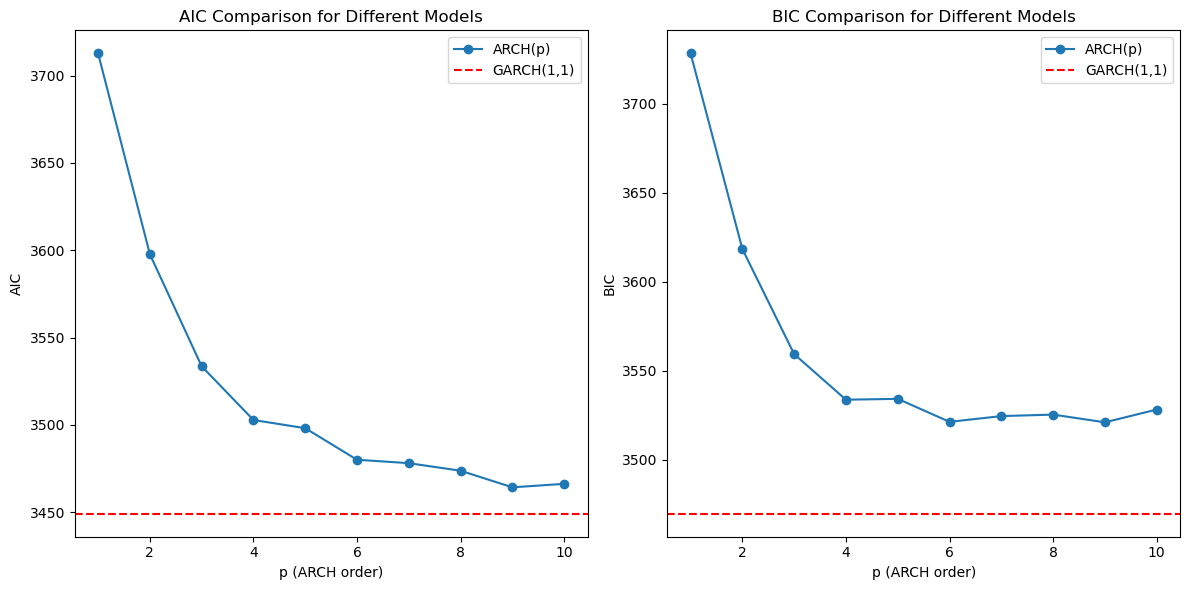

In [66]:
# Compare the best ARCH and GARCH models
print("\nModel Comparison:")
print(f"{'Model':<15} {'AIC':<10} {'BIC':<10} {'Log-Likelihood':<15}")
print("-" * 50)
print(f"ARCH({int(best_arch_bic['p'])}):{best_arch_bic['AIC']:<10.2f} {best_arch_bic['BIC']:<10.2f} {best_arch_bic['Log-Likelihood']:<15.2f}")
print(f"GARCH({int(best_garch_bic['p'])},{int(best_garch_bic['q'])}):{best_garch_bic['AIC']:<10.2f} {best_garch_bic['BIC']:<10.2f} {best_garch_bic['Log-Likelihood']:<15.2f}")

# Visualize the model comparison
plt.figure(figsize=(12, 6))

# AIC comparison
plt.subplot(1, 2, 1)
plt.title('AIC Comparison for Different Models')
arch_results_sorted = arch_results.sort_values('p')
plt.plot(arch_results_sorted['p'], arch_results_sorted['AIC'], 'o-', label='ARCH(p)')
plt.axhline(y=best_garch_aic['AIC'], color='r', linestyle='--', label=f"GARCH({int(best_garch_aic['p'])},{int(best_garch_aic['q'])})")
plt.xlabel('p (ARCH order)')
plt.ylabel('AIC')
plt.legend()


# BIC comparison
plt.subplot(1, 2, 2)
plt.title('BIC Comparison for Different Models')
plt.plot(arch_results_sorted['p'], arch_results_sorted['BIC'], 'o-', label='ARCH(p)')
plt.axhline(y=best_garch_bic['BIC'], color='r', linestyle='--', label=f"GARCH({int(best_garch_bic['p'])},{int(best_garch_bic['q'])})")
plt.xlabel('p (ARCH order)')
plt.ylabel('BIC')
plt.legend()


plt.tight_layout()
plt.show()

## Check model diagnostics

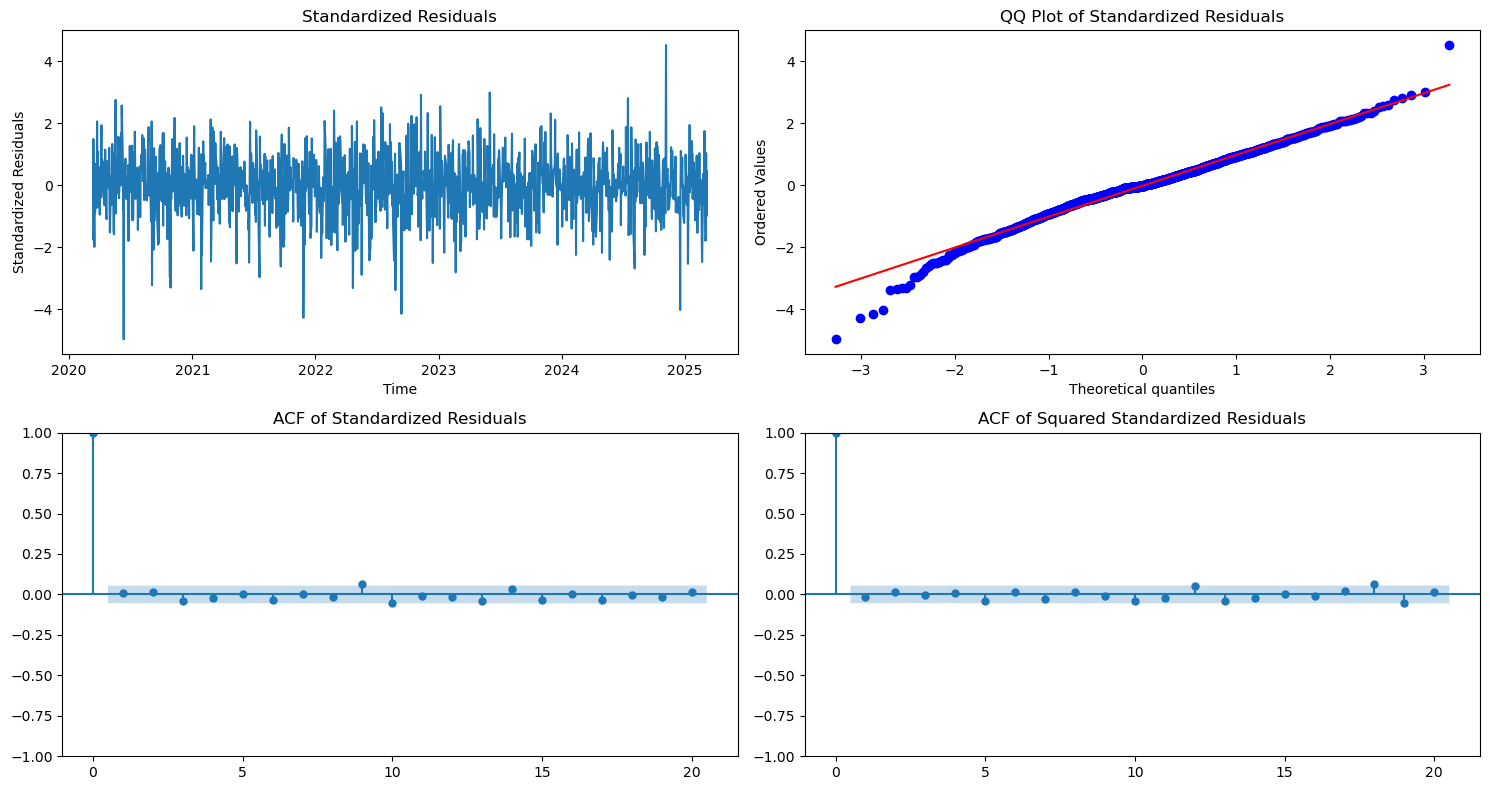

In [71]:
# Plot standardized residuals and QQ plot for the best GARCH model
fig = plt.figure(figsize=(15, 8))

# Get standardized residuals
std_resid = best_garch_result.std_resid

# Standardized residuals plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(std_resid)
ax1.set_title('Standardized Residuals')
ax1.set_xlabel('Time')
ax1.set_ylabel('Standardized Residuals')


# QQ plot
from scipy import stats
ax2 = fig.add_subplot(2, 2, 2)
stats.probplot(std_resid, dist="norm", plot=ax2)
ax2.set_title('QQ Plot of Standardized Residuals')


# ACF of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf
ax3 = fig.add_subplot(2, 2, 3)
plot_acf(std_resid, lags=20, ax=ax3)
ax3.set_title('ACF of Standardized Residuals')


# ACF of squared standardized residuals
ax4 = fig.add_subplot(2, 2, 4)
plot_acf(std_resid**2, lags=20, ax=ax4)
ax4.set_title('ACF of Squared Standardized Residuals')


plt.tight_layout()
plt.show()


## Additional:
## For prediction, let me forecast volatility for the next 10 days

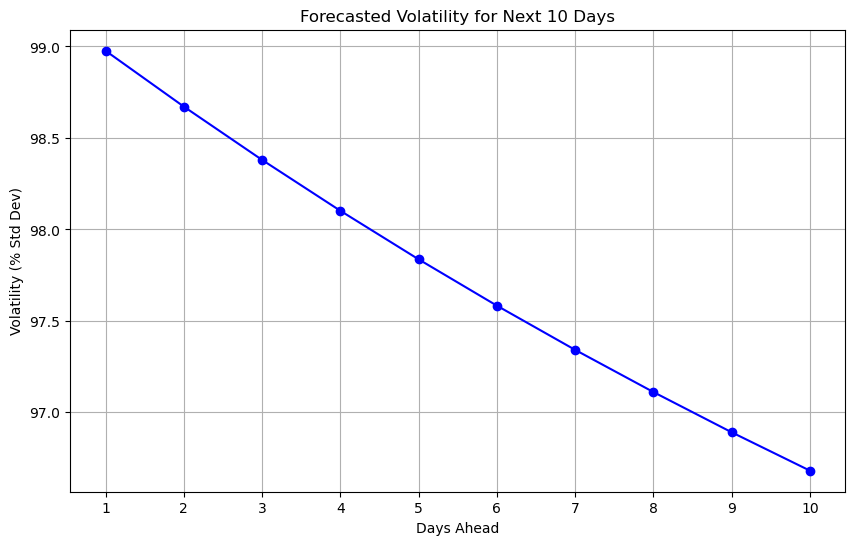

In [85]:
forecast_horizon = 10
forecast = best_garch_result.forecast(horizon=forecast_horizon)
forecasted_variance = forecast.variance.iloc[-1].values

# Plot forecasted volatility
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(forecasted_variance) * 100, 'o-', color='blue')
plt.title(f'Forecasted Volatility for Next {forecast_horizon} Days')
plt.xlabel('Days Ahead')
plt.ylabel('Volatility (% Std Dev)')
plt.grid(True)
plt.xticks(range(forecast_horizon), range(1, forecast_horizon + 1))
plt.show()

## Interpretation

Based on the comprehensive model selection analysis above, the best ARCH(p) model for describing DJIA returns is ARCH(9), which achieves the lowest AIC (3464.22) and BIC (3521.11) values among all ARCH models tested (p=1 to 10). For this model, most of the ARCH parameters are statistically significant, particularly the coefficients for lags 1, 2, 3, 6, and 9. The best GARCH(p,q) model for describing DJIA returns is GARCH(1,1), which outperforms all other GARCH specifications with the lowest AIC (3449.12) and BIC (3469.80) values. The GARCH(1,1) model also demonstrates superior performance compared to the best ARCH model, with a higher log-likelihood (-1720.56 versus -1721.11) and substantially lower AIC and BIC values. All parameters in the GARCH(1,1) model are highly significant, with the persistence parameter (beta[1]=0.84) indicating strong volatility clustering in the DJIA returns. The model comparison clearly shows that the parsimonious GARCH(1,1) specification provides a better fit than even the more complex ARCH(9) model.